In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from functools import reduce


def ecdf(data):
    
    n = len(data)
    
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    
    return x,y

def combination(n, r):
    
    if n - r == 0:
        return 1
    elif r == 0:
        return 1
    
    numerator = reduce(lambda x,y: x*y,range(n,1,-1))
    denominator = reduce(lambda x,y: x*y, range(r,0,-1))
    denominator *= reduce(lambda x,y:x*y, range(1, n-r+1)) 
    
    return numerator//(denominator)

def binomialDistribution(trials,outcomes,probability):
        
    combinations = combination(trials, outcomes)
    success_p = np.power(probability, outcomes)
    fail_p = np.power(1-probability, trials-outcomes)
    
    return combinations*success_p*fail_p

def cbdp(trials,outcomes,probability):
    
    total_probability = 1- reduce(lambda x,y: x+binomialDistribution(trials,y,probability), range(0,outcomes))
        
    return total_probability

def successChance(nAttacker, threshold,toHit_P, multiplier=1):
    
    hits = 0
    probability = 0
        
    for i in range(nAttacker*multiplier,1,-1):
            
        probability = cbdp(nAttacker*multiplier,i,toHit_P)
        if probability >= threshold:
                
            hits = i
            break
        
    return (hits, min(probability,threshold))
    

def enemyUnitsEliminatedByAttackerUnitWithMelee(nAttacker, wsbs, strength,wounds,
                                       toughness, armor, invulnerable=0, ap=0,
                                       attacks=1, damage=1, modifiers = None,
                                       fnp = False, spreadDamage = False, threshold=0.9,
                                       toHitReRoll=False,toWoundReRoll=False):
    
    if modifiers  == None:
        
        toHit_P = 1-((wsbs-1)/6)
        toWound_P = 0
        if strength*2<=toughness:
            toWound_P = 1/6
        elif toughness*2<=strength:
            toWound_P = 1-(1/6)
        elif strength>toughness:
            toWound_P = 1-(2/6)
        elif toughness>strength:
            toWound_P = 2/6
        elif toughness==strength:
            toWound_P = 1/2
            
        toResist_P = armor + ap 
        

        if invulnerable < toResist_P and invulnerable >1:
        
            toDamage_P = 1 - ((invulnerable - 1)/6)
        else:
            
            toResist_P = 0 if toResist_P >= 7 else 1-((toResist_P - 1)/6)

        hits,pHit = successChance(nAttacker, threshold,toHit_P, multiplier=attacks)
        if toHitReRoll == True:
            
        iWounds,pWound = successChance(hits,threshold,toWound_P)
        rWounds,prWounds = successChance(iWounds,threshold,toResist_P)

        
        totalWounds = iWounds - rWounds
        totalWounds = 0 if totalWounds < 0 else totalWounds
        
        kills = totalWounds
        
        if wounds>1 and wounds>damage:
            
            kills = [wound*wounds for wound in range(1,totalWounds+1)]
        
            for i in range(len(kills)):
                
                while kills[i] > 0:
                    
                    kills[i] -= damage
               
            kills = np.array(kills)
            kills = len(kills[kills <= 0])
            
                
        return (kills, pHit, pWound, prWounds,rWounds)        
    

def showResults(kills, pHit, pWound, prWounds, rWounds):
    
    print(str(kills)+" enemy kills with a probability to hit of "+str(pHit)+
      " a probability to wound of "+str(pWound)+
      " and a probability of "+str(prWounds)+" to resist "+str(rWounds)+" wounds")
        

0.629
1.86264514923e-09


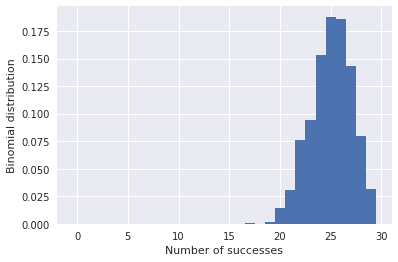

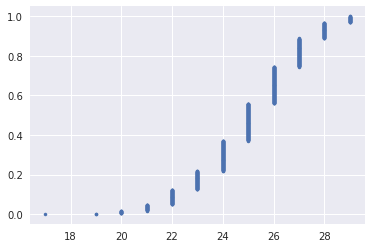

In [48]:
np.random.seed(42)
sns.set()
n_bloodletter_successes = np.random.binomial(30, 1-(1/6), size=1000)

successes = np.sum(n_bloodletter_successes>= 25)

print(successes/1000)
print(cbdp(30,30,0.5))

bins = np.arange(0, max(n_bloodletter_successes)+1.5)-0.5

plt.hist(n_bloodletter_successes,normed=True, bins = bins)
_= plt.xlabel('Number of successes')
_= plt.ylabel('Binomial distribution')

plt.show()

plt.clf()

x,y = ecdf(n_bloodletter_successes)
plt.plot(x,y, marker='.', linestyle='none')
plt.show()

In [124]:
#Bloodletter attacking marine unit with unstopabble ferocity and murderous horde abilities
kills, pHit, pWound, prWounds, rWounds = enemyUnitsEliminatedByAttackerUnitWithMelee(30, 2, 5,2,4, 3, ap=3,
                                       attacks=2, damage=1, threshold=0.9)
showResults(kills, pHit, pWound, prWounds, rWounds)

kills, pHit, pWound, prWounds, rWounds = enemyUnitsEliminatedByAttackerUnitWithMelee(30, 2, 4,2,4, 3,damage=1,
                                                                                     threshold=0.9)
showResults(kills, pHit, pWound, prWounds, rWounds)


25 enemy kills with a probability to hit of 0.9 a probability to wound of 0.9 and a probability of 0.9 to resist 2 wounds
4 enemy kills with a probability to hit of 0.9 a probability to wound of 0.9 and a probability of 0.9 to resist 4 wounds


In [93]:
cbdp(8,1,1-(5/6))

1